TF Tutorial: https://www.tensorflow.org/tutorials/keras/regression

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

*** Parameters

In [3]:
#################################################################
sensor = 2
#################################################################

Read and organize data

In [4]:
sensors = ['98F4AB39DB50', '98F4AB38C884', '4C11AEE82D80']
columns = ['CO2', 'VOC', 'RH', 'TEM', 'PM25', 'TIME', 'SCORE']

csv = f"../resources/{sensors[sensor -1]}-processed.csv"

In [5]:
raw_dataset = pd.read_csv(csv)
dataset = raw_dataset.copy()
dataset = dataset.drop('TIME', axis=1)

In [6]:
dataset.isna().sum()
dataset = dataset.dropna()

In [7]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

Inspect data

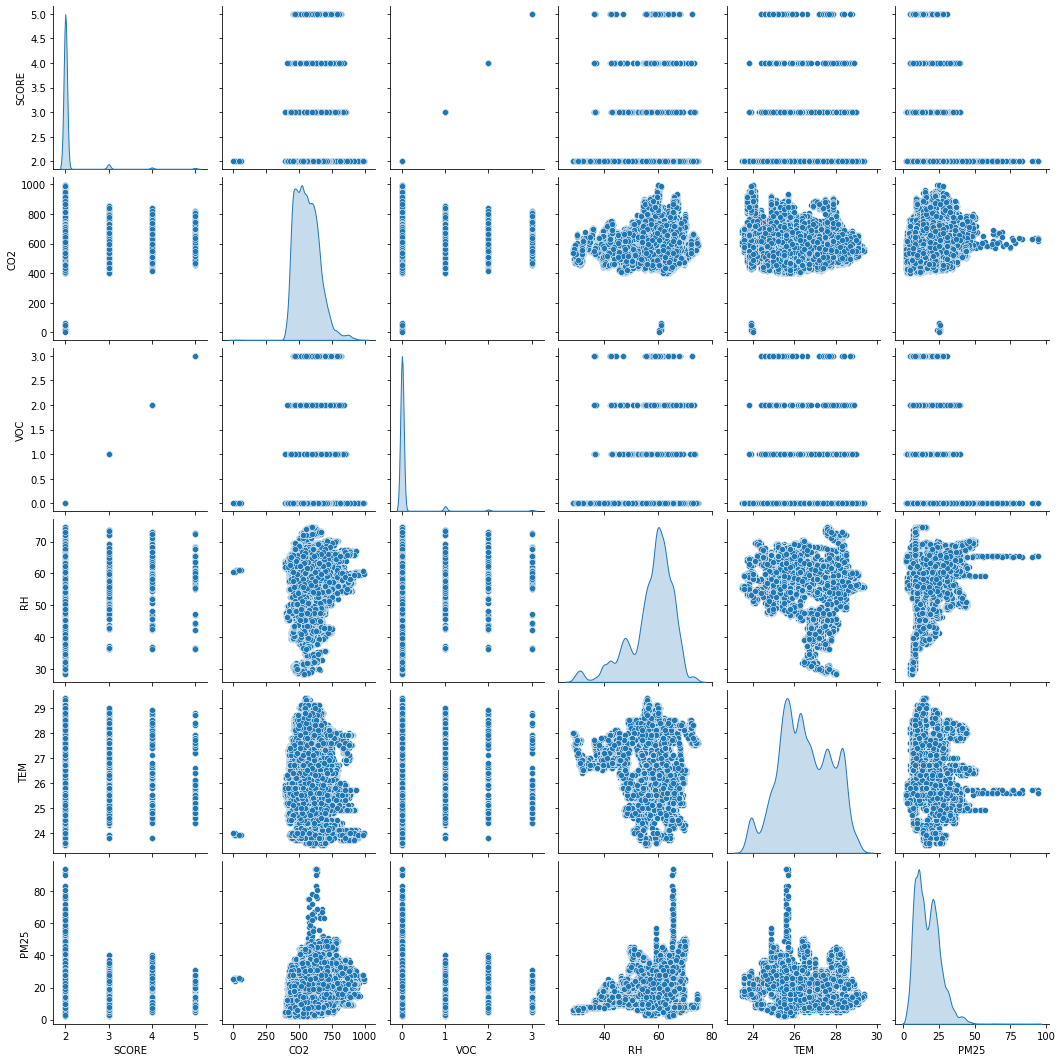

In [8]:
sns.pairplot(train_dataset[['SCORE', 'CO2', 'VOC', 'RH', 'TEM', 'PM25']], diag_kind='kde')


In [9]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CO2,51807.0,562.875075,90.286277,0.0,491.0,554.0,621.0,998.0
VOC,51807.0,0.065570,0.339531,0.0,0.0,0.0,0.0,3.0
RH,51807.0,57.560471,8.152847,28.2,54.2,59.4,62.9,74.7
TEM,51807.0,26.512757,1.252937,23.5,25.6,26.4,27.6,29.4
PM25,51807.0,17.053294,8.472858,2.0,10.0,16.0,22.0,94.0
SCORE,51807.0,2.065570,0.339531,2.0,2.0,2.0,2.0,5.0


In [10]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('SCORE')
test_labels = test_features.pop('SCORE')

Normalization

In [11]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
CO2,562.875075,90.286277
VOC,0.065570,0.339531
RH,57.560471,8.152847
TEM,26.512757,1.252937
PM25,17.053294,8.472858
SCORE,2.065570,0.339531


In [12]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[[562.875   0.066  57.56   26.513  17.053]]


In [13]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[603.    0.   32.2  26.6   7. ]]

Normalized: [[ 0.44 -0.19 -3.11  0.07 -1.19]]


Linear regression with one variable

In [20]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 0.2])
  plt.xlabel('Epoch')
  plt.ylabel('Error [SCORE]')
  plt.legend()
  plt.grid(True)

In [ ]:
test_results = {}

In [24]:
def plot_co2(x, y):
  plt.scatter(train_features['CO2'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('CO2')
  plt.ylabel('SCORE')
  plt.legend()

Regression with a deep neural network (DNN)

In [33]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

Regression using a DNN and multiple inputs

In [40]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 5)                11        
 n)                                                              
                                                                 
 dense_5 (Dense)             (None, 64)                384       
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,620
Trainable params: 4,609
Non-trainable params: 11
_________________________________________________________________


In [41]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: total: 3min 39s
Wall time: 2min 6s


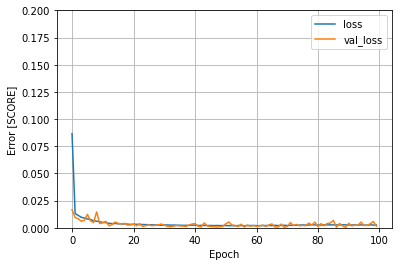

In [42]:
plot_loss(history)

In [43]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

Performance

In [44]:
pd.DataFrame(test_results, index=['Mean absolute error [SCORE]']).T

,Mean absolute error [SCORE]
co2_model,0.087921
linear_model,0.038169
dnn_co2_model,0.066709
dnn_model,0.001544


Predictions

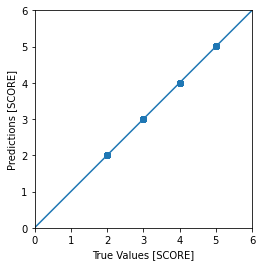

In [45]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [SCORE]')
plt.ylabel('Predictions [SCORE]')
lims = [0, 6]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

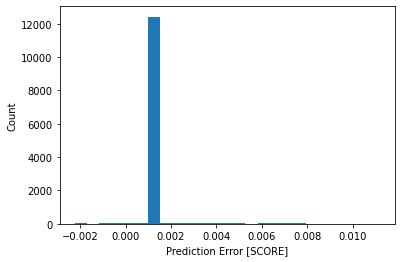

In [46]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [SCORE]')
_ = plt.ylabel('Count')

In [47]:
dnn_model.save(f'dnn_model_sensor_{sensor}')

INFO:tensorflow:Assets written to: dnn_model_sensor_2\assets
